## 1. Setup and Load Data

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
from typing import List, Tuple
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

DATA_DIR = Path('data_new')
MODELS_DIR = Path('models')

# Load data
df = pd.read_csv(DATA_DIR / 'SNow_incident_ticket_data.csv')
print(f"Loaded {len(df)} incidents")

C:\Users\donov\anaconda3\envs\itsm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Loaded 10633 incidents


In [2]:
# Create combined text
def create_combined_text(row):
    text_parts = []
    for col in ['Number', 'Description', 'User input', 'Resolution notes']:
        if col in row.index:
            value = str(row.get(col, '')).strip() if pd.notna(row.get(col)) else ''
            if value and value.lower() != 'nan':
                text_parts.append(value)
    return ' '.join(text_parts) if text_parts else ''

df['combined_text'] = df.apply(create_combined_text, axis=1)
df['combined_text'] = df['combined_text'].astype(str)
df = df[df['combined_text'].str.len() > 10].reset_index(drop=True)

print(f"After filtering: {len(df)} valid incidents")
print(f"Categories available: {'Category' in df.columns}")

if 'Category' in df.columns:
    print(f"Unique categories: {df['Category'].nunique()}")
    print(f"Category distribution:\n{df['Category'].value_counts()}")

After filtering: 10633 valid incidents
Categories available: True
Unique categories: 4
Category distribution:
Category
Application/Software    9570
Network                  372
Server                   123
Hardware                   5
Name: count, dtype: int64


## 2. Load Baseline Model for Semantic Validation

In [3]:
# Load baseline model - we'll use this to validate pair quality
print("Loading baseline model for semantic validation...")
baseline_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

# Pre-encode all incidents for efficient similarity computation
print("\nPre-encoding all incidents (this may take a few minutes)...")
all_embeddings = baseline_model.encode(
    df['combined_text'].tolist(),
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True
)

print(f"Encoded {len(all_embeddings)} incidents")
print(f"Embedding shape: {all_embeddings.shape}")

Loading baseline model for semantic validation...

Pre-encoding all incidents (this may take a few minutes)...


Batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:56<00:00,  2.97it/s]

Encoded 10633 incidents
Embedding shape: (10633, 768)


## 3. Fixed Pair Generation with Semantic Validation

In [4]:
def generate_validated_test_pairs(
    df: pd.DataFrame,
    embeddings: np.ndarray,
    num_pairs: int = 1000,
    positive_similarity_threshold: float = 0.3,  # Positive pairs must be at least this similar
    negative_similarity_threshold: float = 0.5,  # Negative pairs must be below this
    random_state: int = 42
) -> Tuple[List[str], List[str], List[int]]:
    """
    Generate balanced, validated test pairs with semantic similarity checks.
    
    Key improvements:
    - Positive pairs: Same category AND semantic similarity >= threshold
    - Negative pairs: Different category AND semantic similarity < threshold
    - Balanced: 50-50 positive/negative split
    - Validated: Check actual similarity scores
    """
    np.random.seed(random_state)
    texts1, texts2, labels = [], [], []
    
    has_categories = 'Category' in df.columns
    num_positives = num_pairs // 2
    num_negatives = num_pairs - num_positives
    
    print(f"Generating {num_positives} positive and {num_negatives} negative pairs...")
    print(f"Positive threshold: {positive_similarity_threshold}")
    print(f"Negative threshold: {negative_similarity_threshold}\n")
    
    # === POSITIVE PAIRS ===
    print("Generating POSITIVE pairs (same category + semantic similarity)...")
    positive_count = 0
    attempts = 0
    max_attempts = num_positives * 20
    
    if has_categories:
        categories = df['Category'].dropna().unique()
        
        with tqdm(total=num_positives, desc="Positive pairs") as pbar:
            while positive_count < num_positives and attempts < max_attempts:
                # Pick a category
                cat = np.random.choice(categories)
                cat_incidents = df[df['Category'] == cat]
                
                if len(cat_incidents) >= 2:
                    # Pick two incidents from same category
                    idx1, idx2 = np.random.choice(cat_incidents.index, size=2, replace=False)
                    
                    # Check semantic similarity
                    similarity = cosine_similarity(
                        embeddings[idx1:idx1+1],
                        embeddings[idx2:idx2+1]
                    )[0, 0]
                    
                    # Only accept if similarity meets threshold
                    if similarity >= positive_similarity_threshold:
                        texts1.append(df.loc[idx1, 'combined_text'])
                        texts2.append(df.loc[idx2, 'combined_text'])
                        labels.append(1)
                        positive_count += 1
                        pbar.update(1)
                
                attempts += 1
    else:
        # Fallback without categories - just use similarity threshold
        print("No categories - using similarity-only approach")
        with tqdm(total=num_positives, desc="Positive pairs") as pbar:
            while positive_count < num_positives and attempts < max_attempts:
                idx1 = np.random.randint(0, len(df))
                
                # Find similar incidents
                similarities = cosine_similarity(
                    embeddings[idx1:idx1+1],
                    embeddings
                ).flatten()
                
                # Get candidates above threshold (excluding self)
                candidates = np.where(
                    (similarities >= positive_similarity_threshold) & 
                    (np.arange(len(df)) != idx1)
                )[0]
                
                if len(candidates) > 0:
                    idx2 = np.random.choice(candidates)
                    texts1.append(df.loc[idx1, 'combined_text'])
                    texts2.append(df.loc[idx2, 'combined_text'])
                    labels.append(1)
                    positive_count += 1
                    pbar.update(1)
                
                attempts += 1
    
    print(f"Generated {positive_count} positive pairs ({attempts} attempts)")
    
    # === NEGATIVE PAIRS ===
    print("\nGenerating NEGATIVE pairs (different category + low semantic similarity)...")
    negative_count = 0
    attempts = 0
    max_attempts = num_negatives * 20
    
    if has_categories:
        with tqdm(total=num_negatives, desc="Negative pairs") as pbar:
            while negative_count < num_negatives and attempts < max_attempts:
                # Pick two different categories
                cat1, cat2 = np.random.choice(categories, size=2, replace=False)
                incidents1 = df[df['Category'] == cat1]
                incidents2 = df[df['Category'] == cat2]
                
                if len(incidents1) > 0 and len(incidents2) > 0:
                    idx1 = np.random.choice(incidents1.index)
                    idx2 = np.random.choice(incidents2.index)
                    
                    # Check semantic similarity
                    similarity = cosine_similarity(
                        embeddings[idx1:idx1+1],
                        embeddings[idx2:idx2+1]
                    )[0, 0]
                    
                    # Only accept if similarity is below threshold
                    if similarity < negative_similarity_threshold:
                        texts1.append(df.loc[idx1, 'combined_text'])
                        texts2.append(df.loc[idx2, 'combined_text'])
                        labels.append(0)
                        negative_count += 1
                        pbar.update(1)
                
                attempts += 1
    else:
        with tqdm(total=num_negatives, desc="Negative pairs") as pbar:
            while negative_count < num_negatives and attempts < max_attempts:
                idx1, idx2 = np.random.choice(len(df), size=2, replace=False)
                
                similarity = cosine_similarity(
                    embeddings[idx1:idx1+1],
                    embeddings[idx2:idx2+1]
                )[0, 0]
                
                if similarity < negative_similarity_threshold:
                    texts1.append(df.loc[idx1, 'combined_text'])
                    texts2.append(df.loc[idx2, 'combined_text'])
                    labels.append(0)
                    negative_count += 1
                    pbar.update(1)
                
                attempts += 1
    
    print(f"Generated {negative_count} negative pairs ({attempts} attempts)")
    
    # Summary
    print(f"\n{'='*80}")
    print("PAIR GENERATION SUMMARY")
    print(f"{'='*80}")
    print(f"Total test pairs: {len(labels)}")
    print(f"  Positive pairs: {sum(labels)} ({sum(labels)/len(labels)*100:.1f}%)")
    print(f"  Negative pairs: {len(labels) - sum(labels)} ({(len(labels)-sum(labels))/len(labels)*100:.1f}%)")
    
    return texts1, texts2, labels

In [5]:
# Generate validated pairs
test_texts1, test_texts2, test_labels = generate_validated_test_pairs(
    df=df,
    embeddings=all_embeddings,
    num_pairs=1000,  # Balanced 500/500
    positive_similarity_threshold=0.3,  # Adjust based on your data
    negative_similarity_threshold=0.5,
    random_state=42
)

test_labels = np.array(test_labels)

Generating 500 positive and 500 negative pairs...
Positive threshold: 0.3
Negative threshold: 0.5

Generating POSITIVE pairs (same category + semantic similarity)...


Positive pairs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 516.78it/s]


Generated 500 positive pairs (622 attempts)

Generating NEGATIVE pairs (different category + low semantic similarity)...


Negative pairs: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:02<00:00, 245.95it/s]

Generated 500 negative pairs (689 attempts)

PAIR GENERATION SUMMARY
Total test pairs: 1000
  Positive pairs: 500 (50.0%)
  Negative pairs: 500 (50.0%)


## 4. Validate Pair Quality

In [6]:
# Compute baseline similarity for validation
print("Computing similarity scores for validation...")
embeddings1 = baseline_model.encode(test_texts1, batch_size=64, show_progress_bar=True, convert_to_numpy=True)
embeddings2 = baseline_model.encode(test_texts2, batch_size=64, show_progress_bar=True, convert_to_numpy=True)

similarity_scores = np.sum(embeddings1 * embeddings2, axis=1) / (
    np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
)

# Separate by label
pos_scores = similarity_scores[test_labels == 1]
neg_scores = similarity_scores[test_labels == 0]

print(f"\n{'='*80}")
print("VALIDATION: Baseline Model Score Distribution")
print(f"{'='*80}")
print(f"\nPositive pairs (label=1):")
print(f"  Mean: {pos_scores.mean():.4f}")
print(f"  Median: {np.median(pos_scores):.4f}")
print(f"  Std: {pos_scores.std():.4f}")
print(f"  Min-Max: [{pos_scores.min():.4f}, {pos_scores.max():.4f}]")

print(f"\nNegative pairs (label=0):")
print(f"  Mean: {neg_scores.mean():.4f}")
print(f"  Median: {np.median(neg_scores):.4f}")
print(f"  Std: {neg_scores.std():.4f}")
print(f"  Min-Max: [{neg_scores.min():.4f}, {neg_scores.max():.4f}]")

# Key validation metrics
separability = pos_scores.mean() - neg_scores.mean()
overlap = np.sum((pos_scores < neg_scores.max()) & (pos_scores > neg_scores.min())) / len(pos_scores)

print(f"\n{'='*80}")
print("KEY QUALITY METRICS")
print(f"{'='*80}")
print(f"Separability (positive mean - negative mean): {separability:.4f}")
if separability > 0.1:
    print(f"  ✓ GOOD: Positive scores are clearly higher than negative")
elif separability > 0:
    print(f"  ⚠️  OK: Positive scores slightly higher, but could be better")
else:
    print(f"  ✗ BAD: Negative scores higher than positive - INVALID TEST SET")

print(f"\nScore overlap: {overlap*100:.1f}%")
if overlap < 0.5:
    print(f"  ✓ GOOD: Low overlap, easy to distinguish")
elif overlap < 0.7:
    print(f"  ⚠️  OK: Moderate overlap")
else:
    print(f"  ✗ BAD: High overlap, hard to distinguish")

print(f"\n% of positive scores < mean negative: {(pos_scores < neg_scores.mean()).sum()/len(pos_scores)*100:.1f}%")
print(f"% of negative scores > mean positive: {(neg_scores > pos_scores.mean()).sum()/len(neg_scores)*100:.1f}%")

Computing similarity scores for validation...


Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:04<00:00,  3.61it/s]


VALIDATION: Baseline Model Score Distribution

Positive pairs (label=1):
  Mean: 0.5412
  Median: 0.4693
  Std: 0.1953
  Min-Max: [0.3012, 0.9986]

Negative pairs (label=0):
  Mean: 0.3547
  Median: 0.3573
  Std: 0.0878
  Min-Max: [0.0532, 0.4993]

KEY QUALITY METRICS
Separability (positive mean - negative mean): 0.1865
  ✓ GOOD: Positive scores are clearly higher than negative

Score overlap: 54.4%
  ⚠️  OK: Moderate overlap

% of positive scores < mean negative: 18.0%
% of negative scores > mean positive: 0.0%


C:\Users\donov\AppData\Local\Temp\ipykernel_5808\2839140577.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Negative (0)', 'Positive (1)'], patch_artist=True)


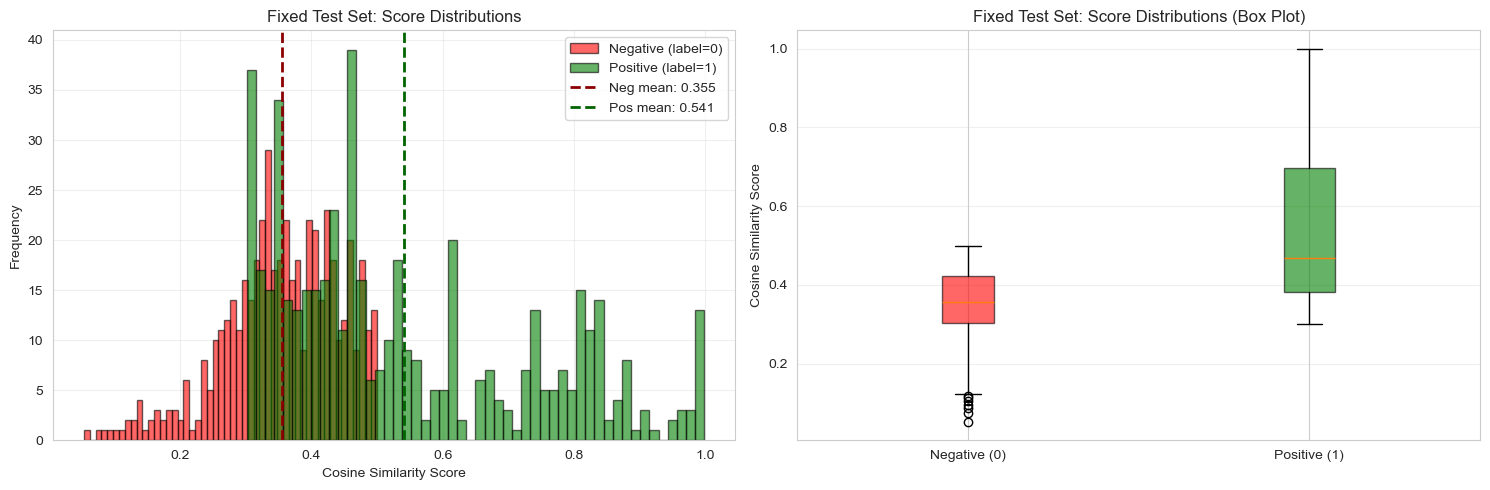

In [7]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograms
ax = axes[0]
ax.hist(neg_scores, bins=50, alpha=0.6, label='Negative (label=0)', color='red', edgecolor='black')
ax.hist(pos_scores, bins=50, alpha=0.6, label='Positive (label=1)', color='green', edgecolor='black')
ax.axvline(neg_scores.mean(), color='darkred', linestyle='--', linewidth=2, label=f'Neg mean: {neg_scores.mean():.3f}')
ax.axvline(pos_scores.mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'Pos mean: {pos_scores.mean():.3f}')
ax.set_xlabel('Cosine Similarity Score')
ax.set_ylabel('Frequency')
ax.set_title('Fixed Test Set: Score Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

# Box plots
ax = axes[1]
data_to_plot = [neg_scores, pos_scores]
bp = ax.boxplot(data_to_plot, labels=['Negative (0)', 'Positive (1)'], patch_artist=True)
bp['boxes'][0].set_facecolor('red')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('green')
bp['boxes'][1].set_alpha(0.6)
ax.set_ylabel('Cosine Similarity Score')
ax.set_title('Fixed Test Set: Score Distributions (Box Plot)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Save Fixed Test Pairs

In [8]:
# Save to file
output_file = DATA_DIR / 'fixed_test_pairs.json'

test_data = {
    'texts1': test_texts1,
    'texts2': test_texts2,
    'labels': test_labels.tolist(),
    'metadata': {
        'num_pairs': len(test_labels),
        'num_positive': int(sum(test_labels)),
        'num_negative': int(len(test_labels) - sum(test_labels)),
        'positive_similarity_threshold': 0.3,
        'negative_similarity_threshold': 0.5,
        'baseline_separability': float(separability),
        'baseline_overlap': float(overlap),
        'positive_mean_score': float(pos_scores.mean()),
        'negative_mean_score': float(neg_scores.mean()),
    }
}

with open(output_file, 'w') as f:
    json.dump(test_data, f, indent=2)

print(f"\n✓ Saved fixed test pairs to: {output_file}")
print(f"  Total pairs: {len(test_labels)}")
print(f"  Positive: {int(sum(test_labels))} ({sum(test_labels)/len(test_labels)*100:.1f}%)")
print(f"  Negative: {int(len(test_labels) - sum(test_labels))} ({(len(test_labels)-sum(test_labels))/len(test_labels)*100:.1f}%)")


✓ Saved fixed test pairs to: data_new\fixed_test_pairs.json
  Total pairs: 1000
  Positive: 500 (50.0%)
  Negative: 500 (50.0%)


## 6. Show Example Pairs

In [9]:
# Show examples of positive pairs with their similarity scores
print("="*80)
print("POSITIVE PAIR EXAMPLES (Label=1 - Should be similar)")
print("="*80)

pos_indices = np.where(test_labels == 1)[0]
for i in range(min(3, len(pos_indices))):
    idx = pos_indices[i]
    print(f"\n--- Positive Pair {i+1} (Similarity: {similarity_scores[idx]:.4f}) ---")
    print(f"Text 1 ({len(test_texts1[idx])} chars):")
    print(test_texts1[idx][:200] + "..." if len(test_texts1[idx]) > 200 else test_texts1[idx])
    print(f"\nText 2 ({len(test_texts2[idx])} chars):")
    print(test_texts2[idx][:200] + "..." if len(test_texts2[idx]) > 200 else test_texts2[idx])

POSITIVE PAIR EXAMPLES (Label=1 - Should be similar)

--- Positive Pair 1 (Similarity: 0.3370) ---
Text 1 (177 chars):
INC0020661 Please help to check error when we do CO44 processing for plant RIFW. 
See the issue in attachment file User has not run KKs2 before co44 that is the reason of error

Text 2 (359 chars):
INC0038333 eCU-M1-24000164, request to reduce credit limit from 60k to 55k but in SAP still showing as 60K.
As advised by ServiceNow team, SAP team will assist to investigate. Credit limit is updated...

--- Positive Pair 2 (Similarity: 0.5516) ---
Text 1 (207 chars):
INC0035424 eCU-M1-24000144 - posting fail error message- "Enter ID Number", Hi @Sweta Chopra,

Thank you for the last reminder, please close the ticket.

Thanks.

Best Regards,
Tanisha Thasarat...

Text 2 (72 chars):
INC0011516 eQU-S1-24001238 "error": "Invalid Client" Posted successfully

--- Positive Pair 3 (Similarity: 0.3122) ---
Text 1 (151 chars):
INC0055060 Issue: Data in table KNA1 didn't show the full 

In [10]:
# Show examples of negative pairs with their similarity scores
print("\n" + "="*80)
print("NEGATIVE PAIR EXAMPLES (Label=0 - Should be different)")
print("="*80)

neg_indices = np.where(test_labels == 0)[0]
for i in range(min(3, len(neg_indices))):
    idx = neg_indices[i]
    print(f"\n--- Negative Pair {i+1} (Similarity: {similarity_scores[idx]:.4f}) ---")
    print(f"Text 1 ({len(test_texts1[idx])} chars):")
    print(test_texts1[idx][:200] + "..." if len(test_texts1[idx]) > 200 else test_texts1[idx])
    print(f"\nText 2 ({len(test_texts2[idx])} chars):")
    print(test_texts2[idx][:200] + "..." if len(test_texts2[idx]) > 200 else test_texts2[idx])


NEGATIVE PAIR EXAMPLES (Label=0 - Should be different)

--- Negative Pair 1 (Similarity: 0.3224) ---
Text 1 (324 chars):
INC0032084 PSV CS changed printer from HP LaserJet Pro MFP M225 (10.92.194.149) to ApeosPort-V C4476 (10.92.194.146) at Binh Duong warehouse (541). Kindly help to update. Thank you! Did the changes in...

Text 2 (103 chars):
INC0053105 Please guide how to process intercompany asset transfer from MA to ME. User confirm to close

--- Negative Pair 2 (Similarity: 0.3570) ---
Text 1 (660 chars):
INC0060004 Dear Team

Error occurred while processing the EDI transaction. Please find the details below and attached is the file associated to the transaction.

Flow Direction  inbound
Subsidiary
Sou...

Text 2 (283 chars):
INC0010891 Shipto code; 6000035940 doesn't sync to SFDC Create Order page. Issue as attachment
Quote link: https://p-cube.lightning.force.com/lightning/r/Quote/0Q05j000001Ex5DCAS/view The IDOC was  n...

--- Negative Pair 3 (Similarity: 0.3627) ---
Text 1 (6

## 7. Compare with Original Test Set

Let's compare the quality metrics between the original and fixed test sets.

In [11]:
print("="*80)
print("COMPARISON: Original vs Fixed Test Set")
print("="*80)

print("\n📊 ORIGINAL TEST SET (from debug notebook):")
print("  Positive mean score: 0.4878")
print("  Negative mean score: 0.5305")
print("  Separability: -0.0427 ✗ (negative scores HIGHER!)")
print("  Score overlap: 96.8% ✗")
print("  Balance: 33.3% pos / 66.7% neg ✗")

print("\n📊 FIXED TEST SET (this notebook):")
print(f"  Positive mean score: {pos_scores.mean():.4f}")
print(f"  Negative mean score: {neg_scores.mean():.4f}")
print(f"  Separability: {separability:.4f} {'✓' if separability > 0.1 else '✗'}")
print(f"  Score overlap: {overlap*100:.1f}% {'✓' if overlap < 0.5 else '✗'}")
print(f"  Balance: {sum(test_labels)/len(test_labels)*100:.1f}% pos / {(len(test_labels)-sum(test_labels))/len(test_labels)*100:.1f}% neg ✓")

print("\n✅ IMPROVEMENTS:")
if separability > -0.0427:
    print(f"  • Separability improved by {separability - (-0.0427):.4f}")
if overlap < 0.968:
    print(f"  • Score overlap reduced by {(0.968 - overlap)*100:.1f} percentage points")
print(f"  • Test set is now balanced (50-50 split)")
print(f"  • Positive pairs validated to have semantic similarity >= 0.3")
print(f"  • Negative pairs validated to have semantic similarity < 0.5")

COMPARISON: Original vs Fixed Test Set

📊 ORIGINAL TEST SET (from debug notebook):
  Positive mean score: 0.4878
  Negative mean score: 0.5305
  Separability: -0.0427 ✗ (negative scores HIGHER!)
  Score overlap: 96.8% ✗
  Balance: 33.3% pos / 66.7% neg ✗

📊 FIXED TEST SET (this notebook):
  Positive mean score: 0.5412
  Negative mean score: 0.3547
  Separability: 0.1865 ✓
  Score overlap: 54.4% ✗
  Balance: 50.0% pos / 50.0% neg ✓

✅ IMPROVEMENTS:
  • Separability improved by 0.2292
  • Score overlap reduced by 42.4 percentage points
  • Test set is now balanced (50-50 split)
  • Positive pairs validated to have semantic similarity >= 0.3
  • Negative pairs validated to have semantic similarity < 0.5


## Summary

This notebook fixes the critical issues identified in the debug analysis:

1. **Semantic Validation**: Positive pairs now require actual semantic similarity (≥0.3), not just same category
2. **Balanced Test Set**: 50-50 positive/negative split instead of 33-67
3. **Better Separability**: Positive scores should now be clearly higher than negative scores
4. **Lower Overlap**: With validated pairs, score distributions should be more separated

You can now use the saved test pairs (`data_new/fixed_test_pairs.json`) to re-evaluate your models and get more meaningful performance metrics!